In [1]:
import numpy as np
import pandas as pd
import datetime

In [2]:
path = "/Users/zehao/Documents/GitHub/MS-Stat-Tulane/Stat Learning in Data Analysis/Project/data/weatherAUS.csv"
data = pd.read_csv(path, dtype={'Location': 'category',
                                'WindGustDir': 'category',
                                'WindDir9am': 'category',
                                'WindDir3pm': 'category'})
data["Date"] = pd.to_datetime(data["Date"])
data = data.dropna(axis=0, subset=["RainTomorrow", "RainToday"])
data[['RainToday', 'RainTomorrow']] = data[[
    'RainToday', 'RainTomorrow']].replace('Yes', 1)
data[['RainToday', 'RainTomorrow']] = data[[
    'RainToday', 'RainTomorrow']].replace('No', 0)

In [3]:
data["year"] = pd.DatetimeIndex(data["Date"]).year
data["month"] = pd.DatetimeIndex(data["Date"]).month

In [4]:
name = data.columns
for j in name:
    if data[j].dtypes == 'float64':
        fillNA = data.groupby(['year', 'month'])[j].transform('median')
        ind = data[j].isna()
        data.loc[data[j].isna(), j] = fillNA[ind]
    elif data[j].dtypes == 'category':
        dummy = pd.get_dummies(data[j], prefix=j)
        data = pd.concat([data, dummy], axis=1)
        del data[j]
del data['year']
del data['month']

In [5]:
x = data.iloc[:, 1:-1]
del x['RainTomorrow']
y = data['RainTomorrow']

In [6]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
logreg = sm.Logit(y_train, x_train)
result = logreg.fit()

Optimization terminated successfully.
         Current function value: 0.346586
         Iterations 8


In [7]:
train_error = logreg.predict(result.params, exog=x_train)
ind_1 = train_error > 0.5
ind_0 = train_error <= 0.5
train_error[ind_1] = 1
train_error[ind_0] = 0

In [8]:
1-np.mean(abs(train_error-y_train))

0.8501540455832868

In [9]:
y_pred = logreg.predict(result.params, exog=x_test)

In [10]:
ind_1 = y_pred > 0.5
ind_0 = y_pred <= 0.5
y_pred[ind_1] = 1
y_pred[ind_0] = 0

In [11]:
1-np.mean(abs(y_pred-y_test))

0.8504510263513033

In [12]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[20758,  1147],
       [ 3064,  3189]])

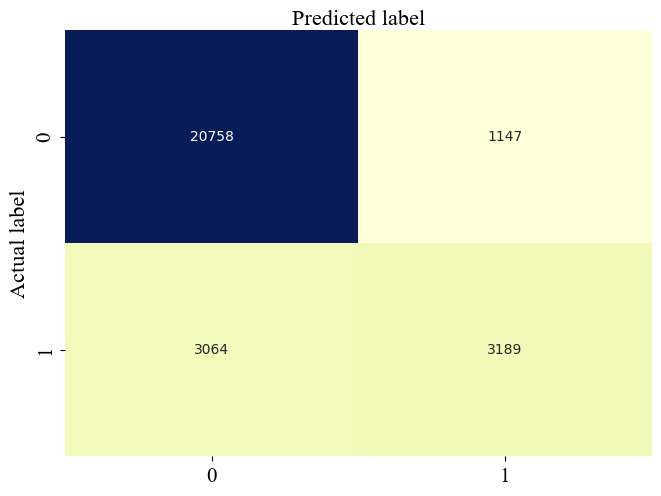

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 16,
}

class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g', cbar=False)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.ylabel('Actual label', font1)
plt.xlabel('Predicted label', font1)


plt.tick_params(labelsize=15)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]

plt.savefig('Logit_confusion_matrix.eps', bbox_inches = 'tight')

plt.show()

In [14]:
from sklearn.metrics import classification_report
target_names = ['Not Raining', 'Raining']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Not Raining       0.87      0.95      0.91     21905
     Raining       0.74      0.51      0.60      6253

    accuracy                           0.85     28158
   macro avg       0.80      0.73      0.76     28158
weighted avg       0.84      0.85      0.84     28158



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


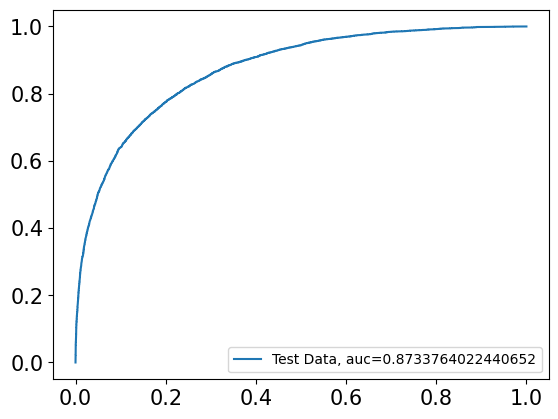

In [25]:
y_pred_proba = logreg.predict(result.params, exog=x_test)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Test Data, auc="+str(auc))
plt.legend(loc=4)

plt.tick_params(labelsize=15)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]

plt.savefig('Roc.eps', bbox_inches = 'tight')

plt.show()